Imports

In [1]:
%load_ext autoreload
%autoreload 2
from translation import BasicBenchmarkTranslator, FJSSPInstancesTranslator, SimpleGAEncoder
from model import Order, ProductionEnvironment, reset_entities, soft_reset
from solver import GASolver, GreedyAgentSolver, PSOSolver
from evaluation import Evaluator, Makespan, IdleTime, TimeDeviation, Profit, UnfulfilledOrders, Tardiness
from visualization import visualize_schedule
import random

<h3>Setup</h3>

In [2]:
order_amount = 10

Data Selection (Only run one of the following blocks)

In [2]:
reset_entities()
fjssp_translator = FJSSPInstancesTranslator()
production_environment = fjssp_translator.translate('6_Fattahi', 1)

In [2]:
reset_entities()
simple_translator = BasicBenchmarkTranslator()
production_environment = simple_translator.translate(3)

Order Generation

In [3]:
def generate_random_orders(amount : int, production_enviornment : ProductionEnvironment) -> list[Order]:
    available_resources = production_enviornment.resources # NOTE: currently works because all resources can be produced
    orders : list[Order] = []
    for i in range(amount):
        resource_id = random.randint(0, len(available_resources)-1)
        resource = production_environment.get_resource(resource_id)
        order = Order(arrival_time=0, delivery_time=1000, latest_acceptable_time=1000, resources=[(resource, 1)], penalty=100.0, tardiness_fee=50.0, divisible=False, profit=500.0) # NOTE: randomize later
        orders.append(order)
    return orders

def generate_one_order_per_recipe(production_environment : ProductionEnvironment) -> list[Order]:
    orders : list[Order] = []
    for i in range(len(production_environment.resources.values())): # should be the same amount as recipes for now
        orders.append(Order(delivery_time=1000, latest_acceptable_time=1000, resources=[(production_environment.get_resource(i), 1)], penalty=100.0, tardiness_fee=50.0, divisible=False, profit=500.0))
    return orders

random.seed(1) # for comparisons

#orders = generate_random_orders(order_amount, production_environment) # NOTE: some of the data is currently the same for every order
orders = generate_one_order_per_recipe(production_environment)

Solver Selection and Configuration (Only run one of the following blocks)

In [138]:
soft_reset()
encoder = SimpleGAEncoder()
values, durations, jobs = encoder.encode(production_environment, orders) # NOTE: create duration dictionary
solver = GASolver(values, durations, jobs, production_environment, orders)

start_time_slot = 0
end_time_slot = 1000
population_size = 100
offspring_amount = 150
max_generations = 1000
crossover = 'two_points' # available options: single_point, two_points, uniform, scattered
selection = 'sss' # available options: sss (Stead State Selection), rws (Roulette Wheel Selection), sus (Stochastic Universal Selection), rank (Rank Selection), random (Random Selection), tournamend (Torunament Selection)
mutation = 'workstation_only' # available options: workstation_only, full_random, random_only_feasible

solver.initialize(earliest_slot=start_time_slot, last_slot=end_time_slot, population_size=population_size, offspring_amount=offspring_amount, max_generations=max_generations, crossover=crossover, selection=selection, mutation=mutation)

In [110]:
soft_reset()
encoder = SimpleGAEncoder()
values, durations, jobs = encoder.encode(production_environment, orders) # NOTE: create duration dictionary
solver = GreedyAgentSolver(values, durations, jobs, production_environment, orders)

In [11]:
soft_reset()
start_time_slot = 0
end_time_slot = 1000
encoder = SimpleGAEncoder()
values, durations, jobs = encoder.encode(production_environment, orders)
solver = PSOSolver(production_environment=production_environment, encoder=encoder, jobs=jobs, durations=durations, start_time=start_time_slot, end_time=end_time_slot, orders=orders)
solver.initialize(dimensions=len(values), max_iterations=10000, update_weights=False, lower_bounds=[start_time_slot] * len(values), upper_bounds=[end_time_slot] * len(values))

Objective Selection (Multiple objectives can be added) NOTE: currently only the first added objective is considered during optimization

In [139]:
solver.add_objective(Makespan())

In [140]:
solver.add_objective(IdleTime())

In [141]:
solver.add_objective(TimeDeviation())

In [142]:
solver.add_objective(Tardiness())

In [143]:
solver.add_objective(Profit())

In [144]:
solver.add_objective(UnfulfilledOrders())

<h3>Run the Solver</h3>

In [145]:
solver.run()
print(solver.get_best())
print(solver.get_best_fitness())

Done
[ 0  0  0  1  0  2  5  4  3  0  9  1  9  3  7  4  6  0  8  1  1  2  3  4
  4  0  4  1  9  4  9  6  8  2  8  3  1  7  3  9  1  9  4 10  0  4  4 14
  6  1  0  5  9  9  4 16  2  0  2  2  3 11  3 16  6  2  6  4  6  8  1 12
  6 12  9 14  0 15  6 18  7  5  8  7  8 12  9 15  2  4  2  9  5 13  1 17
  0  9  8 14  7 16  4 18  7  7  7  9  7 12  8 16]
-20.0


<h3>Evaluation</h3>

If the used Solver provides improvement history:

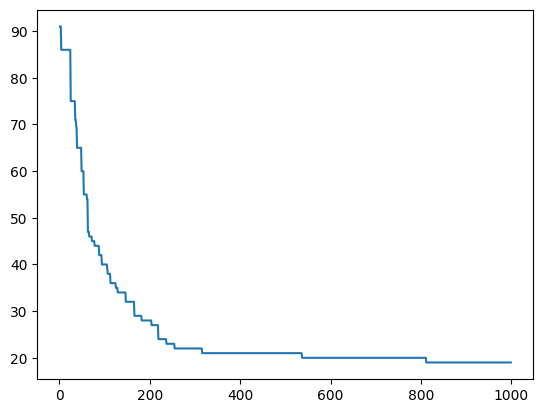

In [146]:
import matplotlib.pyplot as plt
best_history = solver.best_history
generation_average_history = solver.average_history

plt.plot(best_history)
plt.plot(generation_average_history)
plt.show()

In [147]:
schedule = encoder.decode(solver.get_best(), jobs, production_environment, solver=solver)

Visualization

In [148]:
visualize_schedule(schedule, production_environment, orders)

Objective Values

In [149]:
evaluator = Evaluator(production_environment)
evaluator.add_objective(Makespan())
evaluator.add_objective(IdleTime())
evaluator.add_objective(TimeDeviation())
evaluator.add_objective(Tardiness())
evaluator.add_objective(Profit())
evaluator.add_objective(UnfulfilledOrders())
objective_values = evaluator.evaluate(schedule, jobs)
print(f'Solution created with: {solver.name}')
print(objective_values)

Solution created with: GASolver
[20, 51, 14789, 0, 7500.0, 0]


In [150]:
#just testing with python
values = [0, 1, 0, 1, 0, 1, 0, 1]
zeros = values[::2]
ones = values[1::2]
print(zeros)
print(ones)


[0, 0, 0, 0]
[1, 1, 1, 1]
